<div align="center">
    <a href="https://github.com/arogozhnikov/einops">
        <img src="http://arogozhnikov.github.io/images/einops/einops_logo_350x350.png" alt="einops package logo" width="150" height="150" style='padding: 50px 50px 25px;' />
    </a>
    <div>
    <a href="https://github.com/arogozhnikov/einops">[github]</a>, &nbsp;&nbsp;
    tutorials
    <a href="https://github.com/arogozhnikov/einops/blob/master/docs/1-einops-basics.ipynb">[1]</a> and 
    <a href="https://github.com/arogozhnikov/einops/blob/master/docs/2-einops-for-deep-learning.ipynb">[2]</a>    
    <br />
    <br />
    </div>
</div>

# Writing a better code with pytorch and einops


<br /><br />

## Rewriting building blocks of deep learning 

Now let's get to examples from real world.
These code fragments taken from official tutorials and popular repositories.

Learn how to improve code and how `einops` can help you.

**Left**: as it was, **Right**: improved version

In [1]:
#right
# start from importing some stuff
import torch
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
import math

from einops import rearrange, reduce, asnumpy, parse_shape
from einops.layers.torch import Rearrange, Reduce

In [2]:
def initialize(model):
    for p in model.parameters():
        p.data[:] = torch.from_numpy(np.random.RandomState(sum(p.shape)).randn(*p.shape))
    return model

# Simple ConvNet

In [3]:
#left
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

conv_net_old = Net()

In [4]:
#right
conv_net_new = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=5),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(),
    nn.Conv2d(10, 20, kernel_size=5),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(),
    nn.Dropout2d(),
    Rearrange('b c h w -> b (c h w)'),
    nn.Linear(320, 50),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(50, 10),
    nn.LogSoftmax(dim=1)
)

Reasons to prefer new implementation:

- in the original code (to the left) if input size is changed and batch size is divisible by 16 (that's usually so), we'll get something senseless after reshaping
    - new code will explicitly raise an error in this case
- we won't forget to use dropout with flag self.training with new version
- code is straightforward to read and analyze
- sequential makes printing / saving / passing trivial. And there is no need in your code to load a model (which also has a number of benefits)
- don't need logsoftmax? Now you can use `conv_net_new[:-1]`. One more reason to prefer `nn.Sequential`
- ... and we could also add inplace for ReLU


In [5]:
conv_net_old(torch.zeros([16, 1, 20, 20])).shape
# conv_net_new(torch.zeros([16, 1, 20, 20])).shape

torch.Size([4, 10])

# Super-resolution

<!-- minified https://github.com/pytorch/examples/tree/master/super_resolution, withour initialization -->

In [6]:
#left
class SuperResolutionNetOld(nn.Module):
    def __init__(self, upscale_factor):
        super(SuperResolutionNetOld, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

In [7]:
#right
def SuperResolutionNetNew(upscale_factor):
    return nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, upscale_factor ** 2, kernel_size=3, padding=1),
        Rearrange('b (h2 w2) h w -> b (h h2) (w w2)', h2=upscale_factor, w2=upscale_factor),
    )

Here is the difference:

- no need in special instruction pixel_shuffle (and result is transferrable between frameworks)
- output doesn't contain a fake axis (and we could do the same for the input)
- inplace ReLU used now, for high resolution pictures that becomes critical and saves us much memory
- and all the benefits of nn.Sequential again

In [8]:
model1 = initialize(SuperResolutionNetOld(upscale_factor=3))
model2 = initialize(SuperResolutionNetNew(upscale_factor=3))

In [9]:
assert torch.allclose(model1(torch.zeros(1, 1, 30, 30)), model2(torch.zeros(1, 1, 30, 30))[None])

In [10]:
## that's how this code was mentioned to use

# from PIL import Image
# img = Image.open(opt.input_image).convert('YCbCr')
# y, cb, cr = img.split()

# model = torch.load(opt.model)
# img_to_tensor = ToTensor()
# input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0])

# if opt.cuda:
#     model = model.cuda()
#     input = input.cuda()

# out = model(input)
# out = out.cpu()
# out_img_y = out[0].detach().numpy()
# out_img_y *= 255.0
# out_img_y = out_img_y.clip(0, 255)
# out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

# out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
# out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
# out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')

## Benefits

# - no need to remembder the order of components in PIL.Image.size (as you see, it is actually different)
# - code explicitly shows shapes passed in and out
# - normalization to [0, 1] range and back is also explicit (it is needed to rememebed in original code that division by 255 is done by ToTensor)

input_image = '../../logo/einops_logo_350x350.png' 
from PIL import Image
import numpy as np

from torchvision.transforms import ToTensor
model = SuperResolutionNetOld(upscale_factor=2)

img = Image.open(input_image).convert('YCbCr')
y, cb, cr = img.split()

img_to_tensor = ToTensor()
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0])
out = model(input)

out_img_y = out[0].detach().numpy()
out_img_y = np.clip(out_img_y[0] * 255, 0, 255)

model = SuperResolutionNetNew(upscale_factor=2)

img = Image.open(input_image).convert('YCbCr')
y, cb, cr = img.split()

# TODO numpy.asarray
y = torch.from_numpy(np.array(y, dtype='float32') / 255)
out = model(rearrange(y, 'h w -> () () h w'))

out_img_y = asnumpy(rearrange(out, '() h w -> h w'))
out_img_y = np.clip(out_img_y * 255, 0, 255)

# Restyling Gram matrix for style transfer

<!-- from https://github.com/pytorch/examples/blob/29c2ed8ca6dc36fc78a3e74a5908615619987863/fast_neural_style/neural_style/utils.py#L21-L26 -->

Original code is already good - first line shows what kind of input is expected

- einsum operation should be read like:
  - for each batch and for each pair of channels, we sum over h and w.
- I've also changed normalization, because that's how Gram matrix is defined, otherwise we should call it normalized Gram matrix or alike

In [11]:
#left
def gram_matrix_old(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [12]:
#right
def gram_matrix_new(y):
    b, ch, h, w = y.shape
    return torch.einsum('bchw,bdhw->bcd', [y, y]) / (h * w)

It would be great to use just `'b c1 h w,b c2 h w->b c1 c2'`, but einsum supports only one-letter axes

In [13]:
x = torch.randn([32, 128, 40, 40])

In [14]:
%timeit gram_matrix_old(x).sum()
%timeit gram_matrix_new(x).sum()

7.58 ms ± 492 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.66 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
assert torch.allclose(gram_matrix_old(x), gram_matrix_new(x) / 128)

In [16]:
# x = x.to('cuda')
# %timeit -n100 gram_matrix_old(x).sum(); torch.cuda.synchronize()
# %timeit -n100 gram_matrix_new(x).sum(); torch.cuda.synchronize()

# Recurrent model

All we did here is just made information about shapes explicit to skip deciphering

<!-- simplified version of https://github.com/pytorch/examples/blob/master/word_language_model/model.py -->


In [17]:
#left
class RNNModelOld(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""
    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.5):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden
    

In [18]:
#right
class RNNModelNew(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""
    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.5):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(p=dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

    def forward(self, input, hidden):
        t, b = input.shape
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = rearrange(self.drop(output), 't b nhid -> (t b) nhid')
        decoded = rearrange(self.decoder(output), '(t b) token -> t b token', t=t, b=b)
        return decoded, hidden

# Channel shuffle (from shufflenet) 
<!-- from https://github.com/jaxony/ShuffleNet/blob/master/model.py -->

In [19]:
#left
def channel_shuffle_old(x, groups):
    batchsize, num_channels, height, width = x.data.size()

    channels_per_group = num_channels // groups
    
    # reshape
    x = x.view(batchsize, groups, 
        channels_per_group, height, width)

    # transpose
    # - contiguous() required if transpose() is used before view().
    #   See https://github.com/pytorch/pytorch/issues/764
    x = torch.transpose(x, 1, 2).contiguous()

    # flatten
    x = x.view(batchsize, -1, height, width)

    return x

In [20]:
#right
def channel_shuffle_new(x, groups):
    return rearrange(x, 'b (c1 c2) h w -> b (c2 c1) h w', c1=groups)

While progress is obvious, this is not the limit. As you'll see below, we don't even need to write these couple of lines.

In [21]:
x = torch.zeros([32, 64, 100, 100])

In [22]:
%timeit -n100 channel_shuffle_old(x, 8); torch.cuda.synchronize()
%timeit -n100 channel_shuffle_new(x, 8); torch.cuda.synchronize()

51.2 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
49.9 ms ± 594 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Shufflenet

In [23]:
def conv3x3(in_channels, out_channels, stride=1, 
            padding=1, bias=True, groups=1):    
    """3x3 convolution with padding
    """
    return nn.Conv2d(
        in_channels, 
        out_channels, 
        kernel_size=3, 
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups)


def conv1x1(in_channels, out_channels, groups=1):
    """1x1 convolution with padding
    - Normal pointwise convolution When groups == 1
    - Grouped pointwise convolution when groups > 1
    """
    return nn.Conv2d(
        in_channels, 
        out_channels, 
        kernel_size=1, 
        groups=groups,
        stride=1)

In [24]:
#left
from collections import OrderedDict

def channel_shuffle(x, groups):
    batchsize, num_channels, height, width = x.data.size()

    channels_per_group = num_channels // groups
    
    # reshape
    x = x.view(batchsize, groups, 
        channels_per_group, height, width)

    # transpose
    # - contiguous() required if transpose() is used before view().
    #   See https://github.com/pytorch/pytorch/issues/764
    x = torch.transpose(x, 1, 2).contiguous()

    # flatten
    x = x.view(batchsize, -1, height, width)

    return x

class ShuffleUnitOld(nn.Module):
    def __init__(self, in_channels, out_channels, groups=3,
                 grouped_conv=True, combine='add'):
        
        super(ShuffleUnitOld, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.grouped_conv = grouped_conv
        self.combine = combine
        self.groups = groups
        self.bottleneck_channels = self.out_channels // 4

        # define the type of ShuffleUnit
        if self.combine == 'add':
            # ShuffleUnit Figure 2b
            self.depthwise_stride = 1
            self._combine_func = self._add
        elif self.combine == 'concat':
            # ShuffleUnit Figure 2c
            self.depthwise_stride = 2
            self._combine_func = self._concat
            
            # ensure output of concat has the same channels as 
            # original output channels.
            self.out_channels -= self.in_channels
        else:
            raise ValueError("Cannot combine tensors with \"{}\"" \
                             "Only \"add\" and \"concat\" are" \
                             "supported".format(self.combine))

        # Use a 1x1 grouped or non-grouped convolution to reduce input channels
        # to bottleneck channels, as in a ResNet bottleneck module.
        # NOTE: Do not use group convolution for the first conv1x1 in Stage 2.
        self.first_1x1_groups = self.groups if grouped_conv else 1

        self.g_conv_1x1_compress = self._make_grouped_conv1x1(
            self.in_channels,
            self.bottleneck_channels,
            self.first_1x1_groups,
            batch_norm=True,
            relu=True
            )

        # 3x3 depthwise convolution followed by batch normalization
        self.depthwise_conv3x3 = conv3x3(
            self.bottleneck_channels, self.bottleneck_channels,
            stride=self.depthwise_stride, groups=self.bottleneck_channels)
        self.bn_after_depthwise = nn.BatchNorm2d(self.bottleneck_channels)

        # Use 1x1 grouped convolution to expand from 
        # bottleneck_channels to out_channels
        self.g_conv_1x1_expand = self._make_grouped_conv1x1(
            self.bottleneck_channels,
            self.out_channels,
            self.groups,
            batch_norm=True,
            relu=False
            )


    @staticmethod
    def _add(x, out):
        # residual connection
        return x + out


    @staticmethod
    def _concat(x, out):
        # concatenate along channel axis
        return torch.cat((x, out), 1)


    def _make_grouped_conv1x1(self, in_channels, out_channels, groups,
        batch_norm=True, relu=False):

        modules = OrderedDict()
        conv = conv1x1(in_channels, out_channels, groups=groups)
        modules['conv1x1'] = conv

        if batch_norm:
            modules['batch_norm'] = nn.BatchNorm2d(out_channels)
        if relu:
            modules['relu'] = nn.ReLU()
        if len(modules) > 1:
            return nn.Sequential(modules)
        else:
            return conv


    def forward(self, x):
        # save for combining later with output
        residual = x
        if self.combine == 'concat':
            residual = F.avg_pool2d(residual, kernel_size=3, 
                stride=2, padding=1)

        out = self.g_conv_1x1_compress(x)
        out = channel_shuffle(out, self.groups)
        out = self.depthwise_conv3x3(out)
        out = self.bn_after_depthwise(out)
        out = self.g_conv_1x1_expand(out)
        
        out = self._combine_func(residual, out)
        return F.relu(out)

In [25]:
#right
class ShuffleUnitNew(nn.Module):
    def __init__(self, in_channels, out_channels, groups=3, 
                 grouped_conv=True, combine='add'):
        super().__init__()
        first_1x1_groups = groups if grouped_conv else 1
        bottleneck_channels = out_channels // 4
        self.combine = combine
        if combine == 'add':
            # ShuffleUnit Figure 2b
            self.left = Rearrange('...->...') # identity
            depthwise_stride = 1
        else:
            # ShuffleUnit Figure 2c
            self.left = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
            depthwise_stride = 2
            # ensure output of concat has the same channels as original output channels.
            out_channels -= in_channels
            assert out_channels > 0

        self.right = nn.Sequential(
            # Use a 1x1 grouped or non-grouped convolution to reduce input channels
            # to bottleneck channels, as in a ResNet bottleneck module.
            conv1x1(in_channels, bottleneck_channels, groups=first_1x1_groups),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),
            # channel shuffle
            Rearrange('b (c1 c2) h w -> b (c2 c1) h w', c1=groups),
            # 3x3 depthwise convolution followed by batch 
            conv3x3(bottleneck_channels, bottleneck_channels,
                    stride=depthwise_stride, groups=bottleneck_channels),
            nn.BatchNorm2d(bottleneck_channels),
            # Use 1x1 grouped convolution to expand from 
            # bottleneck_channels to out_channels
            conv1x1(bottleneck_channels, out_channels, groups=groups),
            nn.BatchNorm2d(out_channels),
        )        
        
    def forward(self, x):
        if self.combine == 'add':
            combined = self.left(x) + self.right(x)
        else:
            combined = torch.cat([self.left(x), self.right(x)], dim=1)
        return F.relu(combined, inplace=True)


Rewriting the code helped to identify:

- There is no sense in doing reshuffling and not using groups in the first convolution
  (indeed, in the paper it is not so). However, result is an equivalent model.
- It is also strange that the first convolution may be not grouped, while the last convolution is always grouped
  (and that is different from the paper)

Other comments:

- There is an identity layer for pytorch introduced here
- The last thing left is get rid of conv1x1 and conv3x3 in the code - those are not better than standard

In [26]:
model1 = ShuffleUnitOld(32, 32, groups=4, grouped_conv=True, combine='add')
model2 = ShuffleUnitNew(32, 32, groups=4, grouped_conv=True, combine='add')

In [27]:
x = torch.randn(1, 32, 14, 14)
initialize(model1)
initialize(model2)
torch.allclose(model1(x), model2(x))

True

In [28]:
import pickle
dump1 = pickle.dumps(model1._combine_func)
dump2 = pickle.dumps(model2)

# Simplifying ResNet

In [29]:
#left
class ResNetOld(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNetOld, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [30]:
#right
def make_layer(inplanes, planes, block, n_blocks, stride=1):
    downsample = None
    if stride != 1 or inplanes != planes * block.expansion:
        # output size won't match input, so adjust residual
        downsample = nn.Sequential(
            nn.Conv2d(inplanes, planes * block.expansion,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(planes * block.expansion),
        )
    return nn.Sequential(
        block(inplanes, planes, stride, downsample),
        *[block(planes * block.expansion, planes) for _ in range(1, n_blocks)]
    )


def ResNetNew(block, layers, num_classes=1000):    
    e = block.expansion
    
    resnet = nn.Sequential(
        Rearrange('b c h w -> b c h w', c=3, h=224, w=224),
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        make_layer(64,      64,  block, layers[0], stride=1),
        make_layer(64 * e,  128, block, layers[1], stride=2),
        make_layer(128 * e, 256, block, layers[2], stride=2),
        make_layer(256 * e, 512, block, layers[3], stride=2),
        # combined AvgPool and view in one averaging operation
        Reduce('b c h w -> b c', 'mean'),
        nn.Linear(512 * e, num_classes),
    )
    
    # initialization
    for m in resnet.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
    return resnet

Changes:

- explicit check for input shape
- no views and simple sequential structure, output is just nn.Sequential, so can always be saved/passed/etc
- no need in AvgPool and additional views, this place is much clearer now
- `make_layer` doesn't use internal state (that's quite faulty place)

In [31]:
from torchvision.models.resnet import BasicBlock, Bottleneck, ResNet

In [32]:
x = torch.randn(2, 3, 224, 224)
with torch.no_grad():
    model_old = ResNetOld(BasicBlock, layers=[2, 2, 2, 3])
    model_new = ResNetNew(BasicBlock, layers=[2, 2, 2, 3])
    initialize(model_old)
    initialize(model_new)
    assert torch.allclose(model_old(x), model_new(x), atol=1e-3)

In [33]:
# with torch.no_grad():
#     x = torch.randn([2, 512, 7, 7])
#     torch.allclose(nn.AvgPool2d(7)(x), reduce(x, 'b c h w -> b c', 'mean'), atol=1e-8)

# Improving RNN language modelling

In [34]:
#left
class RNNOld(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, 
                           bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(x))
        
        #embedded = [sent len, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim * num directions]
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


In [35]:
#right
class RNNNew(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, 
                           bidirectional=bidirectional, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * self.directions, output_dim)
        
    def forward(self, x):
        #x = [sent len, batch size]        
        embedded = self.dropout(self.embedding(x))
        
        #embedded = [sent len, batch size, emb dim]
        output, (hidden, cell) = self.rnn(embedded)
        
        hidden = rearrange(hidden, '(layer dir) b c -> layer b (dir c)', 
                           dir=self.directions)
        # take the final layer's hidden
        return self.fc(self.dropout(hidden[-1]))


In [36]:
model_old = initialize(RNNOld(10, 10, 10, output_dim=15, n_layers=2, bidirectional=True, dropout=0.1)).eval()
model_new = initialize(RNNNew(10, 10, 10, output_dim=15, n_layers=2, bidirectional=True, dropout=0.1)).eval()

x = torch.randint(0, 10, size=[23, 10]).long()

assert torch.allclose(model_old(x), model_new(x))

In [37]:
# this code fails
# model_old = initialize(RNNOld(10, 10, 10, output_dim=15, n_layers=1, bidirectional=False, dropout=0.1)).eval()
# model_old(x).shape

- original code misbehaves for non-bidirectional models
- ... and fails when bidirectional = False, and there is only one layer
- modification of the code shows both how hidden is structured and how it is modified

# Writing FastText faster

<!-- from # https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/3%20-%20Faster%20Sentiment%20Analysis.ipynb -->

In [38]:
#left
class FastTextOld(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, x):
        
        #x = [sent len, batch size]
        
        embedded = self.embedding(x)
                
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

In [39]:
#right
def FastTextNew(vocab_size, embedding_dim, output_dim):
    return nn.Sequential(
        Rearrange('t b -> t b'),
        nn.Embedding(vocab_size, embedding_dim),
        Reduce('t b c -> b c', 'mean'),
        nn.Linear(embedding_dim, output_dim),
        Rearrange('b c -> b c'),
    )

Some comments on new code:

- first and last operations do nothing and can be removed
    - but were added to explicitly show expected input and output
- this also gives you a flexibility of changing interface by editing a single line. Should you need to accept inputs as (batch, time), 
  you just change first line to `Rearrange('b t -> t b'),`

# CNNs for text classification

In [40]:
#left
class CNNOld(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[0],embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[1],embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[2],embedding_dim))
        self.fc = nn.Linear(len(filter_sizes)*n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [sent len, batch size]
        
        x = x.permute(1, 0)
                
        #x = [batch size, sent len]
        
        embedded = self.embedding(x)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [41]:
#right
class CNNNew(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, n_filters, kernel_size=size) for size in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = rearrange(x, 't b -> t b')
        emb = rearrange(self.embedding(x), 't b c -> b c t')
        pooled = [reduce(conv(emb), 'b c t -> b c', 'max') for conv in self.convs]
        concatenated = rearrange(pooled, 'filter b c -> b (filter c)')
        return self.fc(self.dropout(F.relu(concatenated)))

- Original code misuses Conv2d, while Conv1d is the right choice
- Fixed code can work with any number of filter_sizes (and won't fail)
- First line in new code does nothing, but was added for simplicity

In [42]:
# old_model = initialize(CNNOld(32, 32, 32, [1, 2, 4], 32, dropout=0.1)).eval()
# new_model = initialize(CNNNew(32, 32, 32, [1, 2, 4], 32, dropout=0.1)).eval()

# x = torch.zeros([10, 20]).long()
# assert torch.allclose(old_model(x), new_model(x), atol=1e-3)

# Highway convolutions

- Highway convolutions are common in TTS systems. Code below makes splitting a bit more explicit.
- Splitting policy may eventually turn out to be important if input had previously groups over channel axes (group convolutions or bidirectional LSTMs/GRUs)
- Same applies to GLU and gated units in general

In [43]:
#left
class HighwayConv1dOld(nn.Conv1d):
    def forward(self, inputs):
        L = super(HighwayConv1dOld, self).forward(inputs)
        H1, H2 = torch.chunk(L, 2, 1)  # chunk at the feature dim
        torch.sigmoid_(H1)
        return H1 * H2 + (1.0 - H1) * inputs

In [44]:
#right
class HighwayConv1dNew(nn.Conv1d):
    def forward(self, inputs):
        L = super().forward(inputs)
        H1, H2 = rearrange(L, 'b (split c) t -> split b c t', split=2)
        torch.sigmoid_(H1)
        return H1 * H2 + (1.0 - H1) * inputs

In [45]:
hc1 = HighwayConv1dOld(10, 20, kernel_size=3, padding=1)
hc2 = HighwayConv1dNew(10, 20, kernel_size=3, padding=1)
initialize(hc1)
initialize(hc2)
fw1 = hc1(torch.zeros(1, 10, 100))
fw2 = hc2(torch.zeros(1, 10, 100))
assert torch.allclose(fw1, fw2)

# Tacotron's CBHG module

<!-- https://github.com/r9y9/tacotron_pytorch/blob/master/tacotron_pytorch/tacotron.py -->

In [46]:
#right
class CBHG_Old(nn.Module):
    """CBHG module: a recurrent neural network composed of:
        - 1-d convolution banks
        - Highway networks + residual connections
        - Bidirectional gated recurrent units
    """

    def __init__(self, in_dim, K=16, projections=[128, 128]):
        super(CBHG, self).__init__()
        self.in_dim = in_dim
        self.relu = nn.ReLU()
        self.conv1d_banks = nn.ModuleList(
            [BatchNormConv1d(in_dim, in_dim, kernel_size=k, stride=1,
                             padding=k // 2, activation=self.relu)
             for k in range(1, K + 1)])
        self.max_pool1d = nn.MaxPool1d(kernel_size=2, stride=1, padding=1)

        in_sizes = [K * in_dim] + projections[:-1]
        activations = [self.relu] * (len(projections) - 1) + [None]
        self.conv1d_projections = nn.ModuleList(
            [BatchNormConv1d(in_size, out_size, kernel_size=3, stride=1,
                             padding=1, activation=ac)
             for (in_size, out_size, ac) in zip(
                 in_sizes, projections, activations)])

        self.pre_highway = nn.Linear(projections[-1], in_dim, bias=False)
        self.highways = nn.ModuleList(
            [Highway(in_dim, in_dim) for _ in range(4)])

        self.gru = nn.GRU(
            in_dim, in_dim, 1, batch_first=True, bidirectional=True)

In [47]:
#left
def forward_old(self, inputs):
    # (B, T_in, in_dim)
    x = inputs

    # Needed to perform conv1d on time-axis
    # (B, in_dim, T_in)
    if x.size(-1) == self.in_dim:
        x = x.transpose(1, 2)

    T = x.size(-1)

    # (B, in_dim*K, T_in)
    # Concat conv1d bank outputs
    x = torch.cat([conv1d(x)[:, :, :T] for conv1d in self.conv1d_banks], dim=1)
    assert x.size(1) == self.in_dim * len(self.conv1d_banks)
    x = self.max_pool1d(x)[:, :, :T]

    for conv1d in self.conv1d_projections:
        x = conv1d(x)

    # (B, T_in, in_dim)
    # Back to the original shape
    x = x.transpose(1, 2)

    if x.size(-1) != self.in_dim:
        x = self.pre_highway(x)

    # Residual connection
    x += inputs
    for highway in self.highways:
        x = highway(x)

    # (B, T_in, in_dim*2)
    outputs, _ = self.gru(x)

    return outputs

In [48]:
#right
def forward_new(self, inputs, input_lengths=None):
    x = rearrange(inputs, 'b t c -> b c t')
    _, _, T = x.shape
    # Concat conv1d bank outputs
    x = rearrange([conv1d(x)[:, :, :T] for conv1d in self.conv1d_banks], 
                 'bank b c t -> b (bank c) t', c=self.in_dim)
    x = self.max_pool1d(x)[:, :, :T]

    for conv1d in self.conv1d_projections:
        x = conv1d(x)
    x = rearrange(x, 'b c t -> b t c')
    if x.size(-1) != self.in_dim:
        x = self.pre_highway(x)

    # Residual connection
    x += inputs
    for highway in self.highways:
        x = highway(x)

    # (B, T_in, in_dim*2)
    outputs, _ = self.gru(self.highways(x))

    return outputs    

There is still a large room for improvements, but in this example only forward function was changed

# Simple attention
Good news: there is no more need to guess order of dimensions. Neither for inputs nor for outputs

In [49]:
#left
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
    
    def forward(self, K, V, Q):
        A = torch.bmm(K.transpose(1,2), Q) / np.sqrt(Q.shape[1])
        A = F.softmax(A, 1)
        R = torch.bmm(V, A)
        return torch.cat((R, Q), dim=1)

In [50]:
#right
def attention(K, V, Q):
    _, n_channels, _ = K.shape
    A = torch.einsum('bct,bcl->btl', [K, Q])
    A = F.softmax(A * n_channels ** (-0.5), 1)
    R = torch.einsum('bct,btl->bcl', [V, A])
    return torch.cat((R, Q), dim=1)

In [51]:
args = dict(
    K=torch.zeros(32, 128, 40).cuda(),
    V=torch.zeros(32, 128, 40).cuda(),
    Q=torch.zeros(32, 128, 30).cuda(), 
)
    
%timeit -n100 result_old = Attention()(**args); torch.cuda.synchronize()
%timeit -n100 result_new = attention(**args); torch.cuda.synchronize()

336 µs ± 7.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
336 µs ± 7.48 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
result_old = Attention()(**args); torch.cuda.synchronize()
result_new = attention(**args); torch.cuda.synchronize()
assert torch.allclose(result_old, result_new)

# Transformer's attention needs more attention

In [53]:
#left
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, mask=None):

        attn = torch.bmm(q, k.transpose(1, 2))
        attn = attn / self.temperature

        if mask is not None:
            attn = attn.masked_fill(mask, -np.inf)

        attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = torch.bmm(attn, v)

        return output, attn



class MultiHeadAttentionOld(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k)
        self.w_ks = nn.Linear(d_model, n_head * d_k)
        self.w_vs = nn.Linear(d_model, n_head * d_v)
        nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_v)))

        self.attention = ScaledDotProductAttention(temperature=np.power(d_k, 0.5))
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_v, d_model)
        nn.init.xavier_normal_(self.fc.weight)

        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v, mask=None):
        
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        
        sz_b, len_q, _ = q.size()
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()
        
        residual = q
        
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        
        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv
        
        mask = mask.repeat(n_head, 1, 1) # (n*b) x .. x ..
        output, attn = self.attention(q, k, v, mask=mask)
        
        output = output.view(n_head, sz_b, len_q, d_v)
        output = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)
        
        output = self.dropout(self.fc(output))
        output = self.layer_norm(output + residual)
        
        return output, attn


In [54]:
#right
class MultiHeadAttentionNew(nn.Module):
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()
        self.n_head = n_head
        
        self.w_qs = nn.Linear(d_model, n_head * d_k)
        self.w_ks = nn.Linear(d_model, n_head * d_k)
        self.w_vs = nn.Linear(d_model, n_head * d_v)
        
        nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_v)))
        
        self.fc = nn.Linear(n_head * d_v, d_model)
        nn.init.xavier_normal_(self.fc.weight)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, q, k, v, mask=None):
        residual = q
        q = rearrange(self.w_qs(q), 'b l (head k) -> head b l k', head=self.n_head)
        k = rearrange(self.w_ks(k), 'b t (head k) -> head b t k', head=self.n_head)
        v = rearrange(self.w_vs(v), 'b t (head v) -> head b t v', head=self.n_head)
        attn = torch.einsum('hblk,hbtk->hblt', [q, k]) / np.sqrt(q.shape[-1])
        if mask is not None:
            attn = attn.masked_fill(mask[None], -np.inf)
        attn = torch.softmax(attn, dim=3)
        output = torch.einsum('hblt,hbtv->hblv', [attn, v])
        output = rearrange(output, 'head b l v -> b l (head v)')
        output = self.dropout(self.fc(output))
        output = self.layer_norm(output + residual)
        return output, attn
    

Benefits of new implementation

- we have one module, not two
- now code does not fail for None mask
- the amount of caveats in the original code that we removed is huge. 
  Try erasing comments and deciphering what happens there

In [55]:
# Poor implementation of torch.einsum, so code below doesn't work
class MultiHeadAttentionHard(nn.Module):
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()
        self.w_qs = nn.Parameter(torch.randn(d_model, n_head, d_k) * np.sqrt(2.0 / (d_model + d_k)))
        self.w_ks = nn.Parameter(torch.randn(d_model, n_head, d_k) * np.sqrt(2.0 / (d_model + d_k)))
        self.w_vs = nn.Parameter(torch.randn(d_model, n_head, d_v) * np.sqrt(2.0 / (d_model + d_v)))
        self.w_fc = nn.Parameter(torch.randn(d_model, n_head, d_v) * np.sqrt(2.0 / (d_model + n_head * d_v)))

        self.dropout = nn.Dropout(p=dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, q, k, v, mask=None):
        attn = torch.einsum('bld,dhc,bte,ehc->hblt', [q, self.w_qs, k, self.w_ks])
        if mask is not None:
            attn = attn.masked_fill(mask[None], -np.inf)
        attn = torch.softmax(attn, dim=3)
        output = torch.einsum('hblt,bte,ehv,dhv->hbd', [attn, v, self.w_vs, self.w_fc])
        output = self.dropout(output)
        output = self.layer_norm(output + q)
        return output, attn    

In [56]:
n_heads = 8
d_k = 32
d_v = 64
d_model = 100
t = 51
l = 53
batch = 30

layer1 = initialize(MultiHeadAttentionOld(n_heads, d_k=d_k, d_v=d_v, d_model=d_model)).eval().cuda()
layer2 = initialize(MultiHeadAttentionNew(n_heads, d_k=d_k, d_v=d_v, d_model=d_model)).eval().cuda()

args = dict(
    q=torch.randn(batch, l, d_model),
    k=torch.randn(batch, t, d_model) * 0.1,
    v=torch.randn(batch, t, d_model),
    mask=torch.randn(batch, l, t) > 0,
)
args = {k:v.cuda() for k, v in args.items()}

o1, a1 = layer1(**args)
o2, a2 = layer2(**args)

In [57]:
a1.shape, a2.shape

(torch.Size([240, 53, 51]), torch.Size([8, 30, 53, 51]))

In [58]:
assert torch.allclose(o1, o2)

In [59]:
%timeit -n 200 layer1(**args); torch.cuda.synchronize()
%timeit -n 200 layer2(**args); torch.cuda.synchronize()

4.82 ms ± 73.9 µs per loop (mean ± std. dev. of 7 runs, 200 loops each)
4.6 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 200 loops each)


# Self-attention GANs

SAGANs are currently SotA for image generation, and can be simplified using same tricks.
<!-- If torch.einsum supported non-one letter axes, we could improve this solution further. -->

<!-- from  https://github.com/heykeetae/Self-Attention-GAN/blob/master/sagan_models.py -->

In [60]:
#left
class Self_Attn_Old(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn_Old,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
        self.softmax  = nn.Softmax(dim=-1) #

    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

In [61]:
#right
class Self_Attn_New(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super().__init__()
        self.query_conv = nn.Conv2d(in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros([1]))

    def forward(self, x):
        proj_query = rearrange(self.query_conv(x), 'b c h w -> b (h w) c')
        proj_key = rearrange(self.key_conv(x), 'b c h w -> b c (h w)')
        proj_value = rearrange(self.value_conv(x), 'b c h w -> b (h w) c')
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=2)
        out = torch.bmm(attention, proj_value)
        out = x + self.gamma * rearrange(out, 'b (h w) c -> b c h w',
                                         **parse_shape(x, 'b c h w'))
        return out, attention

In [62]:
model_old = initialize(Self_Attn_Old(128, None))
model_new = initialize(Self_Attn_New(128))

In [63]:
x = torch.randn(2, 128, 30, 30)
assert torch.allclose(model_old(x)[0], model_new(x)[0], atol=1e-4)
# returned attention is transposed
assert torch.allclose(model_old(x)[1], model_new(x)[1], atol=1e-4)

In [64]:
%timeit model_old(x)[0].sum().item()
%timeit model_new(x)[0].sum().item()
# surprise - I had slow down here due to the order of softmax, not einops

15.9 ms ± 990 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.5 ms ± 81.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Improving time sequence prediction

<!-- https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py -->

While this example was considered to be simplistic, I had to analyze surrounding code to understand what kind of input was expected.
You can try yourself. 

Additionally now the code works with any dtype, not only double; and new code supports using GPU.

In [65]:
#left
class SequencePredictionOld(nn.Module):
    def __init__(self):
        super(SequencePredictionOld, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
            
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [66]:
#right
class SequencePredictionNew(nn.Module):
    def __init__(self):
        super(SequencePredictionNew, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future=0):
        b, t = input.shape
        h_t, c_t, h_t2, c_t2 = torch.zeros(4, b, 51, dtype=self.linear.weight.dtype, 
                                           device=self.linear.weight.device)

        outputs = []
        for input_t in rearrange(input, 'b t -> t b ()'):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
            
        for i in range(future): # if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        return rearrange(outputs, 't b () -> b t')

In [67]:
seq_old = SequencePredictionOld().double()
seq_new = SequencePredictionNew().double()
initialize(seq_old)
initialize(seq_new)
x = torch.randn([10, 10], dtype=torch.double)

In [68]:
result_old = seq_old(x)
result_new = seq_new(x)
assert torch.allclose(result_old, result_new)

# Transforming spacial transformer network (STN)


<!-- modified version of https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html -->

In [69]:
#left
class SpacialTransformOld(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x


In [70]:
#right
class SpacialTransformNew(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Spatial transformer localization-network
        linear = nn.Linear(32, 3 * 2)
        # Initialize the weights/bias with identity transformation
        linear.weight.data.zero_()
        linear.bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        self.compute_theta = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            Rearrange('b c h w -> b (c h w)', h=3, w=3),
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            linear,
            Rearrange('b (row col) -> b row col', row=2, col=3),
        )

    # Spatial transformer network forward function
    def stn(self, x):
        grid = F.affine_grid(self.compute_theta(x), x.size())
        return F.grid_sample(x, grid)

- new code will give reasonable errors when passed image size is different from expected
- if batch size is divisible by 18, whatever you input in the old code, it'll fail no sooner than affine_grid.

# Improving GLOW

That's a good old depth-to-space written manually!

Since GLOW is revertible, it will frequently rely on `rearrange`-like operations.

<!-- from https://github.com/chaiyujin/glow-pytorch/blob/master/glow/modules.py -->

In [71]:
#left
def unsqueeze2d_old(input, factor=2):
    assert factor >= 1 and isinstance(factor, int)
    factor2 = factor ** 2
    if factor == 1:
        return input
    size = input.size()
    B = size[0]
    C = size[1]
    H = size[2]
    W = size[3]
    assert C % (factor2) == 0, "{}".format(C)
    x = input.view(B, C // factor2, factor, factor, H, W)
    x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
    x = x.view(B, C // (factor2), H * factor, W * factor)
    return x

def squeeze2d_old(input, factor=2):
    assert factor >= 1 and isinstance(factor, int)
    if factor == 1:
        return input
    size = input.size()
    B = size[0]
    C = size[1]
    H = size[2]
    W = size[3]
    assert H % factor == 0 and W % factor == 0, "{}".format((H, W))
    x = input.view(B, C, H // factor, factor, W // factor, factor)
    x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
    x = x.view(B, C * factor * factor, H // factor, W // factor)
    return x

In [72]:
#right
def unsqueeze2d_new(input, factor=2):
    return rearrange(input, 'b (c h2 w2) h w -> b c (h h2) (w w2)', h2=factor, w2=factor)

def squeeze2d_new(input, factor=2):
    return rearrange(input, 'b c (h h2) (w w2) -> b (c h2 w2) h w', h2=factor, w2=factor)

- term `squeeze` isn't very helpful: which dimension is squeezed? There is `torch.squeeze`, but it's very different.
- in fact, we could skip creating functions completely - it is a single call to `einops` anyway

# Detecting problems in YOLO detection

<!-- mixture of 
    # https://github.com/BobLiu20/YOLOv3_PyTorch/blob/c6b483743598b5f64d520d81e7e5f47ba936d4c9/nets/yolo_loss.py#L28-L44
    # https://github.com/BobLiu20/YOLOv3_PyTorch/blob/c6b483743598b5f64d520d81e7e5f47ba936d4c9/nets/yolo_loss.py#L70-L92
-->

In [73]:
#left
def YOLO_prediction_old(input, num_classes, num_anchors, anchors, stride_h, stride_w):
    bs = input.size(0)
    in_h = input.size(2)
    in_w = input.size(3)
    scaled_anchors = [(a_w / stride_w, a_h / stride_h) for a_w, a_h in anchors]

    prediction = input.view(bs, num_anchors,
                            5 + num_classes, in_h, in_w).permute(0, 1, 3, 4, 2).contiguous()
    # Get outputs
    x = torch.sigmoid(prediction[..., 0])  # Center x
    y = torch.sigmoid(prediction[..., 1])  # Center y
    w = prediction[..., 2]  # Width
    h = prediction[..., 3]  # Height
    conf = torch.sigmoid(prediction[..., 4])  # Conf
    pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred.

    FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
    LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
    # Calculate offsets for each grid
    grid_x = torch.linspace(0, in_w - 1, in_w).repeat(in_w, 1).repeat(
        bs * num_anchors, 1, 1).view(x.shape).type(FloatTensor)
    grid_y = torch.linspace(0, in_h - 1, in_h).repeat(in_h, 1).t().repeat(
        bs * num_anchors, 1, 1).view(y.shape).type(FloatTensor)
    # Calculate anchor w, h
    anchor_w = FloatTensor(scaled_anchors).index_select(1, LongTensor([0]))
    anchor_h = FloatTensor(scaled_anchors).index_select(1, LongTensor([1]))
    anchor_w = anchor_w.repeat(bs, 1).repeat(1, 1, in_h * in_w).view(w.shape)
    anchor_h = anchor_h.repeat(bs, 1).repeat(1, 1, in_h * in_w).view(h.shape)
    # Add offset and scale with anchors
    pred_boxes = FloatTensor(prediction[..., :4].shape)
    pred_boxes[..., 0] = x.data + grid_x
    pred_boxes[..., 1] = y.data + grid_y
    pred_boxes[..., 2] = torch.exp(w.data) * anchor_w
    pred_boxes[..., 3] = torch.exp(h.data) * anchor_h
    # Results
    _scale = torch.Tensor([stride_w, stride_h] * 2).type(FloatTensor)
    output = torch.cat((pred_boxes.view(bs, -1, 4) * _scale,
                        conf.view(bs, -1, 1), pred_cls.view(bs, -1, num_classes)), -1)
    return output

In [74]:
#right
def YOLO_prediction_new(input, num_classes, num_anchors, anchors, stride_h, stride_w):
    raw_predictions = rearrange(input, 'b (anchor prediction) h w -> prediction b anchor h w', 
                                anchor=num_anchors, prediction=5 + num_classes)
    anchors = torch.FloatTensor(anchors).to(input.device)
    anchor_sizes = rearrange(anchors, 'anchor dim -> dim () anchor () ()')

    _, _, _, in_h, in_w = raw_predictions.shape
    grid_h = rearrange(torch.arange(in_h).float(), 'h -> () () h ()').to(input.device)
    grid_w = rearrange(torch.arange(in_w).float(), 'w -> () () () w').to(input.device)

    predicted_bboxes = torch.zeros_like(raw_predictions)
    predicted_bboxes[0] = (raw_predictions[0].sigmoid() + grid_w) * stride_w  # center x
    predicted_bboxes[1] = (raw_predictions[1].sigmoid() + grid_h) * stride_h  # center y
    predicted_bboxes[2:4] = (raw_predictions[2:4].exp()) * anchor_sizes  # bbox width and height
    predicted_bboxes[4] = raw_predictions[4].sigmoid()  # confidence
    predicted_bboxes[5:] = raw_predictions[5:].sigmoid()  # class predictions
    # merging all predicted bboxes for each image
    return rearrange(predicted_bboxes, 'prediction b anchor h w -> b (anchor h w) prediction')

We changed and fixed a lot:

- new code won't fail if input is not on the first GPU
- old code has wrong grid_x and grid_y for non-square images
- new code doesn't use replication when broadcasting is sufficient
- old code strangely sometimes takes `.data`, but this has no real effect, as some branches preserve gradient till the end
    - if gradients not needed, torch.no_grad should be used, so it's redundant

# Simpler output for a bunch of pictures

Next time you need to output drawings of you generative models, you can use this trick

<!-- # from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html -->

In [75]:
fake_batch = torch.rand([100, 3, 1, 1]) + torch.zeros([100, 3, 32, 32])
from matplotlib import pyplot as plt
import torchvision.utils as vutils

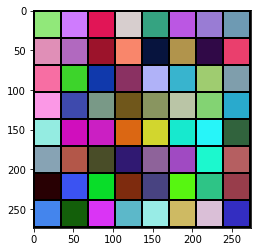

In [76]:
#right
device = 'cpu'
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

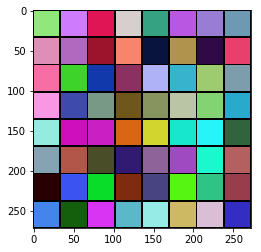

In [77]:
#right
padded = F.pad(fake_batch[:64], [1, 1, 1, 1])
plt.imshow(rearrange(padded, '(b1 b2) c h w -> (b1 h) (b2 w) c', b1=8).cpu())

In [78]:
# TODO: Hierarchical softmax 
# TODO: some reinforcement stuff would also be needed

# Instead of conclusion

Better code is a vague term; to be specific, code is expected to be:

- reliable: does what expected and does not fail. Explicitly fails for wrong inputs
- maintainable and modifiable
- reusable: understanding and modifying code should be easier than writing from scratch
- fast: in my measurements, proposed versions have speed similar to the original code
- readability counts, as a mean to achieve previous goals

Provided examples show how to improve these criteria for deep learning code. And `einops` helps a lot.

# Links

- [pytorch](http://github.com/pytorch/pytorch) and [einops](https://github.com/arogozhnikov/einops)
- significant part of the code was taken from the official [examples](https://github.com/pytorch/examples) and [tutorials](https://github.com/pytorch/tutorials). All code fragments were taken for educational purpose.
- (references for other code are given in source of this html)
- einops has a [tutorial](https://github.com/arogozhnikov/einops/tree/master/docs) for a more gentle introduction